# Classificação de textos do Twitter com spaCy

# Etapa 1: Importação e instalação das bibliotecas

In [1]:
pip install spacy==2.2.3

     |████████████████████████████████| 10.4 MB 6.7 MB/s 
     |████████████████████████████████| 2.2 MB 53.1 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [2]:
import spacy
spacy.__version__

'2.2.3'

In [5]:
!python3 -m spacy download pt

     |████████████████████████████████| 21.2 MB 1.1 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=093bbc8ea82e5b5718804dc58e354bbc5d0588ca2d7d36b3a7290caa343b4657
  Stored in directory: /tmp/pip-ephem-wheel-cache-8aalxb1c/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [6]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np 
import re
import matplotlib.pyplot as plt
%matplotlib inline 

# Etapa 2: Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

## Base de treinamento

- Negative label: 0
- Positive label: 1

In [7]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter=';')
base_treinamento.shape

(50000, 5)

In [8]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [9]:
base_treinamento.tail()

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


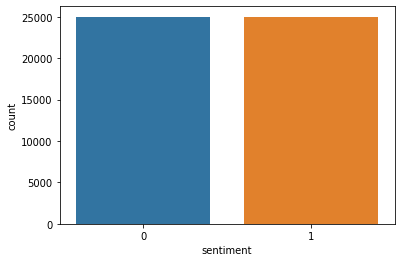

In [10]:
sns.countplot(x=base_treinamento['sentiment'], label='Contagem')
plt.show()

In [11]:
base_treinamento.drop(['id','tweet_date','query_used'],axis=1, inplace=True)

In [12]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


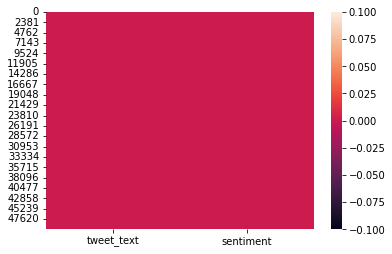

In [18]:
sns.heatmap(pd.isnull(base_treinamento))
plt.show()

## Base de teste

In [13]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [15]:
base_teste.shape

(5000, 5)

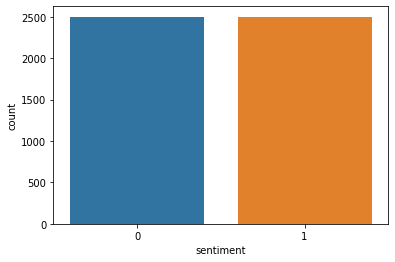

In [16]:
sns.countplot(x='sentiment', data=base_teste)
plt.show()

In [17]:
base_teste.drop(['id','tweet_date','query_used'],axis=1, inplace=True)
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


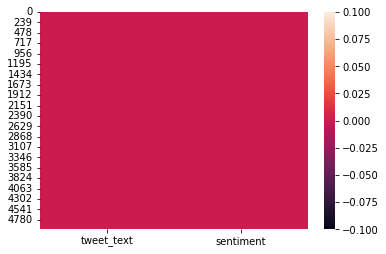

In [19]:
sns.heatmap(pd.isnull(base_teste))
plt.show()

# Etapa 3: Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [20]:
pln = spacy.load('pt')
pln

In [21]:
base_treinamento['tweet_text'][1]

'@behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [24]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS 
print(stop_words)

{'em', 'vossa', 'adeus', 'maiorias', 'sois', 'for', 'tentar', 'ele', 'se', 'vens', 'ou', 'estas', 'pouca', 'neste', 'eles', 'tenho', 'esse', 'número', 'breve', 'isso', 'quatro', 'talvez', 'entre', 'mais', 'ali', 'nada', 'sétimo', 'quem', 'dizem', 'cada', 'das', 'segunda', 'sua', 'onze', 'minhas', 'teve', 'aí', 'estes', 'eventual', 'caminho', 'tuas', 'tu', 'nesta', 'já', 'poder', 'tempo', 'nove', 'dois', 'outros', 'saber', 'posso', 'teu', 'fui', 'vários', 'devem', 'nessa', 'estão', 'poderá', 'eu', 'dentro', 'apoia', 'fazia', 'certamente', 'vindo', 'como', 'essa', 'bom', 'menor', 'próximo', 'era', 'seus', 'faz', 'estava', 'aquele', 'conhecido', 'ver', 'vinda', 'sexto', 'dez', 'pouco', 'tua', 'ontem', 'as', 'ao', 'sobre', 'cima', 'à', 'outra', 'seria', 'de', 'foram', 'zero', 'todo', 'sim', 'vossos', 'põem', 'tem', 'lado', 'demais', 'aqueles', 'pelas', 'nossos', 'todas', 'próprio', 'vos', 'tanta', 'quarto', 'os', 'quinto', 'fora', 'menos', 'vinte', 'cujo', 'agora', 'usar', 'pelo', 'após', 

In [25]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [53]:
def preprocessamento(texto):
  # Letra minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r'@[A-Za-z0-9$-_@.&+]+', ' ', texto)

  #URLs
  texto = re.sub(r'https?://[A-Za-z0-9./]+', ' ', texto)

  # Espaçoes em branco
  texto = re.sub(r' +',' ', texto)
  
  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}

  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  #Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)

  # Stop words
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation] 
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

In [49]:
texto_teste = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'

In [54]:
resultado = preprocessamento(texto_teste)
print(resultado)

  emocaopositiva parir emocaonegativa mim precisamente o contrário emocaopositiva vir o chuva e vir o disposição emocaopositiva


# Etapa 4: Pré-processamento da base de dados

### Limpeza dos textos

In [55]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [56]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)


In [57]:
base_treinamento.head(10)

,tweet_text,sentiment
0,o pessoa certo parir seriar o valer e azeved...,1
1,parir mim precisamente o contrário emocaopos...,1
2,video hoje ... pensar falar sobrar o meter csg...,1
3,aaaaaaaa amar polaroids expressar o quantum to...,1
4,valorizar o coração menino vc diferente o sorr...,1
5,amigo to emocaopositiva,1
6,bravo jairo emocaopositiva,1
7,socorrer ksoaksosks achar to o caixa som :p,1
8,gostar fazenda emocaopositiva morrer medo ga...,1
9,amanhar venom emocaopositiva,1


In [58]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [60]:
base_teste.head(10)

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1
5,preciso emocaopositiva,1
6,acaso adorar beijo e abraço hahahahaha bue f...,1
7,solteiro s emocaopositiva,1
8,lindeza cortador kit mário coleção bia cravol ...,1
9,claro emocaopositiva,1


### Tratamento da classe

In [61]:
exemplo_base_dados = [['este trabalho é agradável', {'POSITIVO':True, 'NEGATIVO':False}],
                      ['este lugar continua assustador'], {'POSITIVO':False, 'NEGATIVO':True}]

In [67]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO':True, 'NEGATIVO':False})
  elif emocao == 0:
    dic = ({'POSITIVO':False, 'NEGATIVO':True})
  
  base_dados_treinamento_final.append([texto, dic.copy()])

In [68]:
len(base_dados_treinamento_final)

50000

In [70]:
base_dados_treinamento_final[10:15]

[['simplesmente o deixar chatear querer muitooo e iludir emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['o comedir umar rotina e perfeitamente parir consolidar o escola condução :p',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['amigar parecer apaixonar vc — recíproco emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  gajar bacano aleijar esperar e o silvar feliz emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['tou o video cabra bebé emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}]]

In [71]:
base_dados_treinamento_final[45000:45005]

[['o menino pijama listrar o filmar triste mundo estruturar nenhum pra assistir rever e to pensar n emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['pra o vídeo luísa raiz o poliana infelizmente o twitter tá ruim amanhã postar emocaonegativa asaventurasdepoliana099',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['to crise abstinência strangers emocaonegativa — tbm :/ to',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['  esquecer olhar pra pagar o mensalidade turma pro cursar querer emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['querer comer doce comer montar hoje emocaonegativa maldição',
  {'NEGATIVO': True, 'POSITIVO': False}]]

# Etapa 5: Criação do classificador

In [72]:
modelo = spacy.blank('pt') # modelo vazio em portugues
categorias = modelo.create_pipe('textcat') # pipe de categorização de texto 
categorias.add_label('POSITIVO') # adiciona label para categoria positivo
categorias.add_label('NEGATIVO') # adiciona label para categoria negativo
modelo.add_pipe(categorias) # adiciona categorias no modeloo
historico = [] # lista de históricos para acompanhamento de resultados

In [73]:
modelo.begin_training() # começamos o treinamento 
for epoca in range(20): # 20 épocas 
  random.shuffle(base_dados_treinamento_final) # embaralhamos os dados
  losses = {} # dicionário para armazenar valor dos erros
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512): # pegamos um batch de 512 registros 
    textos = [modelo(texto) for texto, entities in batch] # lista com os textos de cada um dos registros do batch
    annotations = [{'cats': entities} for texto, entities in batch] # lista com os dicionários de cada entity dos registros do batch
    modelo.update(textos, annotations, losses=losses) # atualização dos pesos
    historico.append(losses) # adicionamos o erro no histórico
  if epoca % 5 == 0: # mostramos os valores dos erros para as epocas específicas
    print(losses)

{'textcat': 9.586853086329672e-06}
{'textcat': 5.325923756018328e-07}
{'textcat': 4.787328370661412e-08}
{'textcat': 4.497735170449265e-08}
{'textcat': 2.999373280910308e-08}
{'textcat': 2.995623022577533e-08}


In [78]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [79]:
historico_loss = np.array(historico_loss)
historico_loss

array([9.58685309e-06, 9.58685309e-06, 9.58685309e-06, ...,
       2.99487514e-08, 2.99487514e-08, 2.99487514e-08])

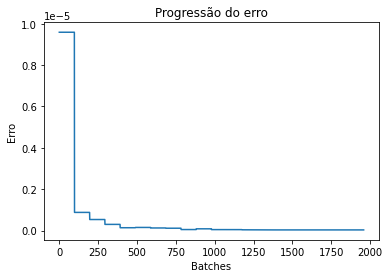

In [80]:
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')
plt.show()

In [81]:
modelo.to_disk('modelo')

# Etapa 6: Testes com uma frase

In [84]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

In [85]:
texto_positivo = base_teste['tweet_text'][21]

In [86]:
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [87]:
previsao = modelo_carregado(texto_positivo)
previsao

  ficar feliz q recíproco emocaopositiva

In [88]:
previsao.cats

{'NEGATIVO': 5.776793841505423e-05, 'POSITIVO': 0.9999545812606812}

In [89]:
texto_positivo = 'eu gosto muito de você'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar'

In [90]:
modelo_carregado(texto_positivo).cats

{'NEGATIVO': 0.26174396276474, 'POSITIVO': 0.353007048368454}

In [91]:
base_teste['tweet_text'][4000]

'tô triste filmar mulan o mushu emocaonegativa'

In [92]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'NEGATIVO': 0.9999545812606812, 'POSITIVO': 4.539786823443137e-05}

# Etapa 7: Avaliação do modelo

## Avaliação na base de treinamento


In [93]:
previsoes = []
for texto in base_treinamento['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [ ]:
previsoes

In [95]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [96]:
previsoes_final

array([1, 1, 1, ..., 0, 0, 0])

In [97]:
respostas_reais = base_treinamento['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [98]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.99996

In [99]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[24998,     2],
       [    0, 25000]])

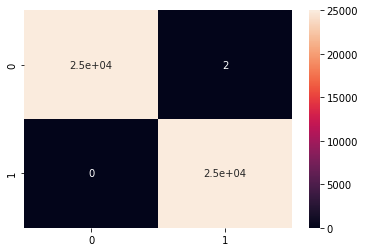

In [101]:
sns.heatmap(cm, annot=True);

## Avaliação na base de teste

In [102]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [103]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [104]:
respostas_reais = base_teste['sentiment'].values
respostas_reais

array([1, 1, 1, ..., 0, 0, 0])

In [105]:
accuracy_score(respostas_reais, previsoes_final)

0.997

In [106]:
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2493,    7],
       [   8, 2492]])

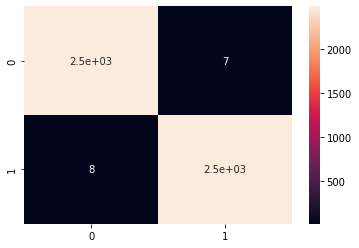

In [107]:
sns.heatmap(cm, annot=True);